# Living Planet Symposium 2025

# First Steps in accessing Satellite Imagery on Copernicus Data Space Ecosystem with Sentinel Hub APIs

The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.

In [67]:
# Utilities
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import geopandas as gpd
import contextily as cx
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,    
    parse_time,
)

from utils import plot_image

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [2]:
# Only run this cell if you have not created a configuration.

#config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [3]:
config = SHConfig("cdse")

## Setting an area of interest

The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

In [4]:
aoi_coords_wgs84 = [16.180953, 48.104673, 16.511572, 48.287298]

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [5]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (2421, 2073) pixels


## Process API

### Example 1: True Color Image

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastCC` which will return pixels from the least cloudy acquisition in the specified time period.

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands.

The least cloudy image from the time period is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [6]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2025-05-01", "2025-05-20"),
            #other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [7]:
true_color_imgs = request_true_color.get_data()

In [8]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2073, 2421, 3)


Image type: uint8


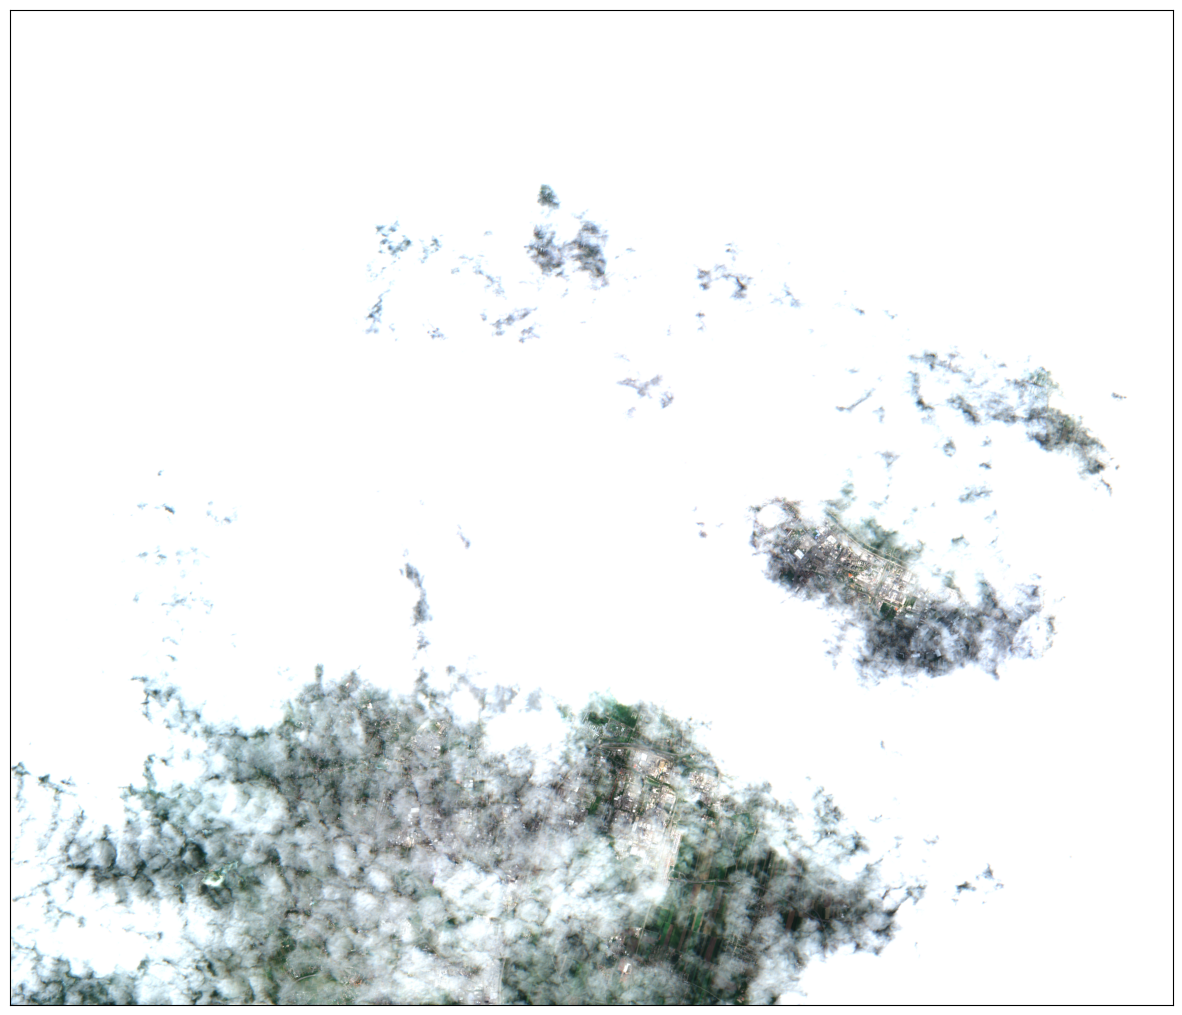

In [9]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

### Example 2: NDVI Image

Secondly, we will also show you an example of how to calculate and visualise NDVI using the same API. NDVI is a very commonly used spectral vegetation index for vegetation monitoring, for example, monitoring crop growth and yields. As you will notice in the codeblock below, the evalscript has changed substantially:
- we are only using Band 4 and Band 8 as an input into our script.
- In the `evaluatePixel()` function, we calculate NDVI and visualise this using the `imgVals` array. 

In [10]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2025-05-01", "2025-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The same method as before is used to request and then visualise the data. In the visualisation, the lighter greens indicate a higher NDVI value (vegetation, forest) and the darker greens (urban areas and water bodies) represent areas with lower NDVI values.

In [11]:
ndvi_img = request_ndvi_img.get_data()

In [12]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2073, 2421, 3)


Image type: uint8


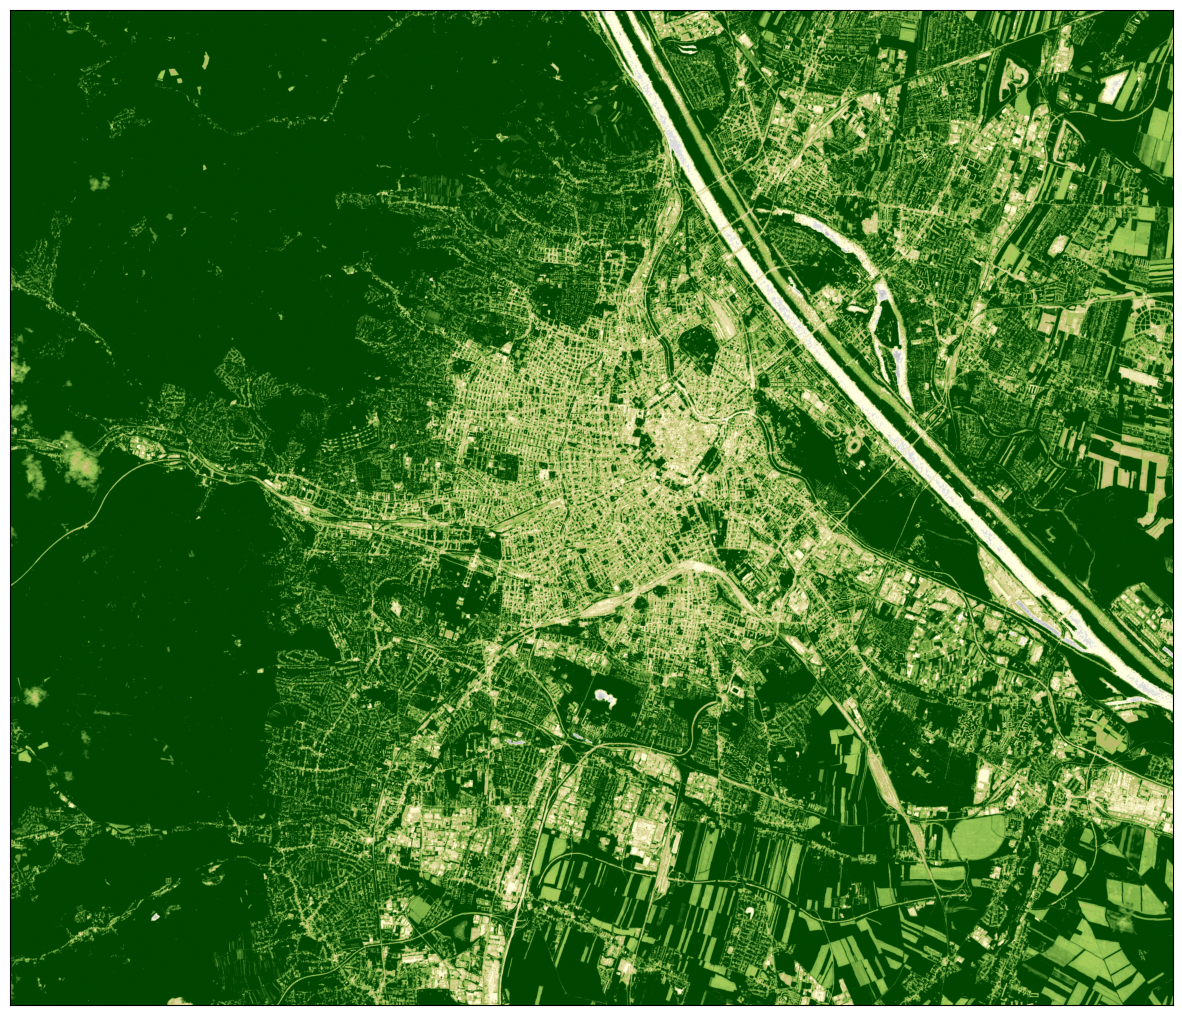

In [13]:
image = ndvi_img[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1 / 255)

## Visualising CLMS datasets

## Statistical API

In the Process API examples, we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Creating a field of interest

Firstly, we will define some fields of interest in France for the first few examples. We will use the [Sentinel-2 L2A](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html) data collection in the first examples though.

In [69]:
fields = """
{
"type": "FeatureCollection",
"name": "austria_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3857" } },
"features": [
{ "type": "Feature", "properties": { "fid": 1285619, "RFL_ID": 108015743.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 3.405187, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203406200171/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203406200171.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203406200171/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203406200171.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2020-02-12T13:42:07", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363031342E3938383134333720323730353639362E363735353131383220343830363031332E363931383538373820323730353639312E393333323537323720343830363031372E393130333130303320323730353637312E353533353930333520343830363032372E383731333734363120323730353633362E313830303834323520343830363037302E323039333530323220323730353437382E353139393232333220343830363139372E393531353434343920323730353438382E383136393633303920343830363230352E373632393032363820323730353439322E303435353939363520343830363231332E363730313533393620323730353530302E323831333931343120343830363137382E3639353039383120323730353636352E343836383634323520343830363137312E383439323334333920323730353639322E313531333136353720343830363136322E303331323937313420323730353731302E333033363937323720343830363135372E333639393139353120323730353731332E383037313332343720343830363135312E353335313535393320323730353731342E3932383232323420343830363131392E373634303135383720323730353731312E383132393530383720343830363131352E393335373333303820323730353731312E303430383839363920343830363130332E313837323832383920323730353730392E363438353039303320343830363033352E313831363937303420323730353639352E393732323232363520343830363032322E323236323936333920323730353639352E383136373630393920343830363031342E3938383134333720323730353639362E3637353531313832203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 854.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827245.85460563423112, 5987194.588551948778331 ], [ 1827243.370380397187546, 5987187.780263729393482 ], [ 1827247.0430196239613, 5987157.27132124453783 ], [ 1827257.285728002665564, 5987103.979268457740545 ], [ 1827299.918946804711595, 5986866.722664936445653 ], [ 1827488.418557854136452, 5986865.542153110727668 ], [ 1827500.265457244822755, 5986869.291698739863932 ], [ 1827512.869939968688414, 5986880.392147633247077 ], [ 1827481.964454774977639, 5987127.805090847425163 ], [ 1827475.216012011049315, 5987167.892069781199098 ], [ 1827463.062276459531859, 5987195.84132192377001 ], [ 1827456.661578974220902, 5987201.589120746590197 ], [ 1827448.247417634585872, 5987203.983426792547107 ], [ 1827401.294971028110012, 5987203.462158123031259 ], [ 1827395.588530506007373, 5987202.815970424562693 ], [ 1827376.73091236455366, 5987202.397379309870303 ], [ 1827275.366690668510273, 5987190.974384196102619 ], [ 1827256.358148422557861, 5987192.400952845811844 ], [ 1827245.85460563423112, 5987194.588551948778331 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1286827, "RFL_ID": 108010016.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 18.368332, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203401500014/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203401500014.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203401500014/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203401500014.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2017-01-23T22:16:00", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830353734322E363735333031373420323730353337392E313831383231353620343830353832322E393836373230383920323730343735322E393039313031363620343830353832362E373534393539343520323730343735302E3038313535333420343830363032382E393732303736343120323730343832382E313632383535343420343830363033332E303136373032313820323730343833332E353937323436353320343830363034302E323131373431363120323730343933302E313833343739383220343830363034322E393330313231303320323730343937312E393039353732363220343830363034382E393136393735393820323730353031392E343738313133313820343830363038322E323934343430353620323730353132342E363936313133363420343830363039362E333732343838313920323730353137342E383933363735313420343830363130332E383039343933323520323730353232352E37383438363820343830363130322E333637373532393420323730353237372E3335393434333520343830363039352E393231323033323820323730353332312E363339393937383620343830363039342E333032393738363520323730353332372E393533323639383620343830363037322E313033323532323820323730353431312E3935323638393520343830363036302E353238303338343820323730353435342E3430383635383220343830363035352E363139353336323920323730353435372E333138363837373420343830353930342E393831323631303920323730353432312E363636343938393420343830353836392E313033383835393720323730353431332E363438373331343120343830353734362E303833313133323720323730353338342E303730353438343220343830353734322E363735333031373420323730353337392E3138313832313536203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 920.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1826807.622585895936936, 5986762.474575977772474 ], [ 1826848.234849396627396, 5985831.320449212566018 ], [ 1826853.40924621745944, 5985826.681841840036213 ], [ 1827159.377465040888637, 5985915.669120309874415 ], [ 1827165.974231104366481, 5985923.143154987134039 ], [ 1827188.413550951750949, 5986064.243723629973829 ], [ 1827197.536311129340902, 5986125.25087030697614 ], [ 1827212.168995603919029, 5986194.431797341443598 ], [ 1827274.04630285478197, 5986344.884408954530954 ], [ 1827300.862509782193229, 5986416.89908083435148 ], [ 1827318.031330853933468, 5986490.782653839327395 ], [ 1827322.271591496188194, 5986566.806057645939291 ], [ 1827318.278081396361813, 5986632.743707299232483 ], [ 1827316.684048287570477, 5986642.234084282070398 ], [ 1827294.494411431485787, 5986768.591951441951096 ], [ 1827282.758869512239471, 5986832.503207293339074 ], [ 1827275.923005741322413, 5986837.409581060521305 ], [ 1827050.742999553913251, 5986804.223971929401159 ], [ 1826997.170666819904, 5986797.015554131940007 ], [ 1826813.219185540219769, 5986769.228487577289343 ], [ 1826807.622585895936936, 5986762.474575977772474 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1287047, "RFL_ID": 108266839.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 12.127094, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100035/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100035.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100035/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100035.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2017-01-23T22:16:00", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363638322E373433343333363720323730353035352E393830303539363720343830363638332E393631373036323820323730353035332E363336323436323120343830373234302E303835383432333420323730353036372E363334393932373220343830373231392E333733313538373220323730353239352E393339313437363620343830373231362E313830323537373820323730353239392E3230373331313420343830373136312E363136313235303720323730353330342E343634383435313320343830363934382E3732383335313820323730353333362E333037303837393320343830363832372E343930353538373220323730353333332E3235313833313520343830363736352E323530393734313220323730353137362E303433383139323120343830363735352E333631303732353420323730353135362E353130373533313720343830363734332E3133383931363920323730353133382E323231363532353220343830363638322E373433343333363720323730353035352E3938303035393637203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 616.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1828145.58664693729952, 5986167.090891021303833 ], [ 1828147.083062309538946, 5986163.48872506711632 ], [ 1828963.841035352088511, 5986112.903518505394459 ], [ 1828961.672522438922897, 5986451.255743359215558 ], [ 1828957.396506718359888, 5986456.470218824222684 ], [ 1828878.07606403157115, 5986471.18765895627439 ], [ 1828569.994501803768799, 5986545.261653937399387 ], [ 1828391.928185331635177, 5986556.283416159451008 ], [ 1828281.315968015231192, 5986333.080591690726578 ], [ 1828264.412093504332006, 5986305.623848236165941 ], [ 1828244.243652038509026, 5986280.294645157642663 ], [ 1828145.58664693729952, 5986167.090891021303833 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1288672, "RFL_ID": 108069009.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 10.395215, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100072/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100072.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100072/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100072.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2017-01-23T22:16:00", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363230322E343430333339313720323730343437302E333732363531363420343830363230322E353233373834363920323730343436362E3038363930353920343830363231362E303236383432323720323730343435322E383637333937363420343830363234352E343330383338343320323730343431382E353834373638393720343830363330322E323336383032303720323730343337362E353331343533323220343830363335382E323635383738313720323730343333342E32363933343720343830363438322E343531313033383720323730343233382E343934363031393420343830363536352E333630333539313320323730343137372E313230333636323120343830363538392E373635303236383320323730343230312E303838373536383720343830363630332E3531383933323420323730343231332E323536363635373220343830363631332E353231333732363420323730343232312E313732353239323120343830363632372E303031303639333220323730343233302E393539333937333120343830363633382E383430383438373920323730343233382E363039333138343820343830363634392E343031373533343220323730343234342E373434303933363520343830363636342E353734303235383520323730343235322E333938373435333220343830363638312E373335353532363820323730343235372E313233303732353520343830363638302E303334343433363220323730343235382E343036373731343520343830363639372E3138363930373120323730343236332E333335393436343220343830363639302E3837363234383720323730343332332E353231383334373620343830363638372E393238393733383120323730343335392E383536333331363120343830363334322E3730393534353920323730343632302E343032343635303920343830363230322E343430333339313720323730343437302E3337323635313634203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 953.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827369.528221862623468, 5985367.441029831767082 ], [ 1827369.12263303110376, 5985361.129104856401682 ], [ 1827387.282233088510111, 5985339.967694828286767 ], [ 1827426.148930787341669, 5985285.806324467994273 ], [ 1827504.21309506543912, 5985216.719138179905713 ], [ 1827581.111862561432645, 5985147.424061576835811 ], [ 1827751.290076610166579, 5984990.742738700471818 ], [ 1827865.218491764273494, 5984889.912528466433287 ], [ 1827903.934001046000049, 5984922.031153936870396 ], [ 1827925.588119876571, 5984938.162183507345617 ], [ 1827941.220971334259957, 5984948.521400341764092 ], [ 1827962.179922969313338, 5984961.186808911152184 ], [ 1827980.472450816305354, 5984970.920086443424225 ], [ 1827996.70423334161751, 5984978.589259013533592 ], [ 1828019.880743251880631, 5984987.903348707593977 ], [ 1828045.611048866529018, 5984992.654834096319973 ], [ 1828043.276552282972261, 5984994.759650454856455 ], [ 1828069.018865678226575, 5984999.813394010998309 ], [ 1828067.191260131075978, 5985089.106781903654337 ], [ 1828067.351827000500634, 5985142.903755269013345 ], [ 1827593.568654931150377, 5985570.107640437781811 ], [ 1827369.528221862623468, 5985367.441029831767082 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1289075, "RFL_ID": 108041908.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 7.186696, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100052/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100052.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100052/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100052.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2017-01-23T22:16:00", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363332372E3035373132303320323730343731362E383135303437393420343830363332322E353831373832303820323730343639382E393130383738323220343830363333352E373336373837333220323730343633392E313230333432393420343830363336372E353632343137323520323730343637302E303639393737363820343830363339352E383731323737393720323730343639312E373536393739313120343830363432322E3237323330363920323730343730372E323930313231313520343830363439332E323539333130343120323730343734302E343039333534383420343830363531332E383333393431313420323730343735352E323839363538373220343830363532382E343739383436363120323730343736392E383833373730343620343830363534302E353930313737333720323730343738372E363931393030373620343830363535302E373432313535343920323730343830372E373038383633333220343830363635332E383535323239393920323730353034332E353634393632373820343830363431312E333636323333313120323730353033382E333336393332343420343830363430362E333936353738313820323730353033342E333637393535383820343830363332372E3035373132303320323730343731362E3831353034373934203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 719.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827582.509621815523133, 5985713.865830066613853 ], [ 1827573.745020183501765, 5985688.112592314369977 ], [ 1827585.65654269955121, 5985598.519903073087335 ], [ 1827636.109825797611848, 5985639.958663059398532 ], [ 1827680.268393783597276, 5985668.227646538056433 ], [ 1827720.872967279981822, 5985687.692113175988197 ], [ 1827828.985650439513847, 5985727.314437142573297 ], [ 1827860.971821221755818, 5985746.563256904482841 ], [ 1827884.234315495472401, 5985766.149163485504687 ], [ 1827904.177222537109628, 5985790.784935466013849 ], [ 1827921.522560516837984, 5985818.91886340547353 ], [ 1828101.718132541747764, 5986152.530401583760977 ], [ 1827745.689628589898348, 5986175.847844732925296 ], [ 1827737.917061764979735, 5986170.647081059403718 ], [ 1827582.509621815523133, 5985713.865830066613853 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1290549, "RFL_ID": 107943454.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 20.060314, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203401500039/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203401500039.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203401500039/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203401500039.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2019-02-24T16:29:20", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830353336302E313931303530303120323730353237332E313030313239373720343830353335392E343036313233313720323730353236382E363832333734393420343830353336342E383236343236303920323730353235302E303632353934373620343830353336362E3136323633303620323730353234332E343233363336363720343830353337302E353337303337353920323730353233302E343439313530383920343830353338362E393830303239363920323730353138312E363737373630383120343830353339322E3434353030323120323730353135352E3438343036333520343830353339352E313035313232373520323730353133302E313032353538333220343830353339362E383531363035343620323730353130342E333636363237303620343830353339382E313334393737383620323730353037382E383637323335363520343830353339392E39393839393120323730353035352E393239353337313320343830353430342E383730353439373220323730353033322E393137313536333320343830353431312E313037393833373720323730353031312E313035353838383820343830353432302E313230383636343220323730343938382E3733383738393920343830353433302E393034383632383220323730343936372E383937323837343620343830353435352E3739323430303820323730343933322E373539303237343120343830353438342E353937373031393320323730343930342E3538373139393320343830353439372E383631313933393420323730343839342E343937353038363220343830353535332E333937393133333720323730343834322E333339383933313520343830353539372E3530373938323120323730343830332E323939333531383820343830353634372E3438303939363120323730343736322E313833373630373220343830353636352E353332353633393920323730343734302E313132333739353320343830353637372E363432313432313420323730343732312E333133393238343620343830353638372E313632383231323920323730343730302E363837333237383120343830353639322E353233303933353520323730343639382E343938343830353720343830353831332E353533313839383620323730343734352E323835343237373420343830353831372E3430333136383720323730343735302E373733373233383120343830353734332E323732323830323520323730353333352E303231333737303120343830353733382E3138373132303320323730353337352E313034333636393920343830353733372E383131393239323120323730353337382E303631363432393520343830353733332E343135313031353820323730353338312E303835383935323520343830353634372E383634333431323420323730353336322E3638343633303120343830353531392E303136333637363720323730353332382E353038363232363620343830353435342E373033373032393420323730353331302E343635363532333120343830353432372E353538303939383120323730353239332E373435303939343320343830353431302E303730323839383420323730353238362E343134313032353320343830353336302E313931303530303120323730353237332E3130303132393737203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 1457.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1826233.970253467094153, 5986655.291615686379373 ], [ 1826232.276412565493956, 5986648.895366312935948 ], [ 1826237.930495951790363, 5986620.823280168697238 ], [ 1826239.072313408832997, 5986610.890169130638242 ], [ 1826243.887816709466279, 5986591.253056391142309 ], [ 1826261.988486674148589, 5986517.437126790173352 ], [ 1826266.776247113011777, 5986478.22238402068615 ], [ 1826267.552987086120993, 5986440.559938319027424 ], [ 1826266.947078813798726, 5986402.493028583005071 ], [ 1826265.691534148762003, 5986364.833183279260993 ], [ 1826265.602095408830792, 5986330.866299103014171 ], [ 1826269.911367549793795, 5986296.406063445843756 ], [ 1826276.370146022411063, 5986263.537455041892827 ], [ 1826286.828280112473294, 5986229.498464353382587 ], [ 1826300.069686386734247, 5986197.47650614194572 ], [ 1826332.222341054352, 5986142.63297160435468 ], [ 1826370.973338678712025, 5986097.533414199948311 ], [ 1826389.170773883815855, 5986081.005117187276483 ], [ 1826464.146861719200388, 5985997.22594740614295 ], [ 1826523.98917208542116, 5985934.19226043112576 ], [ 1826592.167643572902307, 5985867.359269617125392 ], [ 1826615.906903908587992, 5985832.602269681170583 ], [ 1826631.34061101381667, 5985803.416096600703895 ], [ 1826642.755183259490877, 5985771.872354759834707 ], [ 1826650.341399974888191, 5985767.969844338484108 ], [ 1826833.471403333824128, 5985821.315127694047987 ], [ 1826839.78917924920097, 5985828.89346057549119 ], [ 1826803.061277317814529, 5986697.45959347859025 ], [ 1826800.542386401677504, 5986757.051591250114143 ], [ 1826800.356524505419657, 5986761.448236426338553 ], [ 1826794.284459178103134, 5986766.456814681179821 ], [ 1826666.629095647484064, 5986750.318492650054395 ], [ 1826473.573255743598565, 5986716.506531550548971 ], [ 1826377.091610695933923, 5986698.180381611920893 ], [ 1826335.247910300735384, 5986677.055968789383769 ], [ 1826308.714635806158185, 5986668.50675431266427 ], [ 1826233.970253467094153, 5986655.291615686379373 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1293441, "RFL_ID": 107991674.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 15.556506, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100053/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100053.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100053/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100053.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2020-10-07T22:25:05", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363037382E333235333738353220323730353034362E313636343131363120343830363038302E313539393833393520323730353034322E303639323536383620343830363039332E393931323231323820323730353034312E393632353338333620343830363238342E383235323933343720323730353034362E343236373133313920343830363430312E303734323031353420323730353034382E373832373635323320343830363430342E383036323139393620323730353035302E3834383031333920343830363434392E323338353632303320323730353232382E363633343436313520343830363435372E323132303536383620323730353236302E353932373937333120343830363435382E303433323936313520323730353236332E393138333032343820343830363436362E323130323634303920323730353239362E353839373434313220343830363438382E343131343437373620323730353338352E343234373636323920343830363531372E353738393833303220323730353530322E313733353334363420343830363531342E353639333531393220323730353530352E363637363330303620343830363431372E383536303431393220323730353439362E313339353334363620343830363234382E333636393130393120323730353438312E313833373732383220343830363038312E353837303431333320323730353436362E333531383337363820343830363037392E353037393136323820323730353436332E323332393235353920343830363038352E323833343038363420323730353433312E323638313238323520343830363039352E323338363138323120323730353339362E3730343434353820343830363130332E383331393230313820323730353337362E303134313139393620343830363131312E3533353632303520323730353334372E323734323835313720343830363131392E303034303436343720323730353330372E373337303730373720343830363132302E393032343831323420323730353238382E313432333635343520343830363132342E363931373438333820323730353238382E323334363834353220343830363132332E303338313830383520323730353236362E303539353230323420343830363132322E323431313538303220323730353232302E363534383432323420343830363131362E343535343238313320323730353137332E3536373334313620343830363130392E313039373933343520323730353134332E333334383333353920343830363039342E373238333431383420323730353039342E313332333237303320343830363037382E333235333738353220323730353034362E3136363431313631203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 1228.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827258.55655868910253, 5986229.918385926634073 ], [ 1827260.740684627089649, 5986223.659456582739949 ], [ 1827280.998399592237547, 5986221.735664567910135 ], [ 1827561.231334927491844, 5986203.916718065738678 ], [ 1827731.893369086319581, 5986192.52313666138798 ], [ 1827737.617465372895822, 5986195.082853903062642 ], [ 1827824.655223964946344, 5986450.868691341020167 ], [ 1827840.277414727956057, 5986496.800070192664862 ], [ 1827841.905656249029562, 5986501.583825764246285 ], [ 1827857.903091554297134, 5986548.581914982758462 ], [ 1827901.394202403957024, 5986676.373429831117392 ], [ 1827958.538986996747553, 5986844.323241324163973 ], [ 1827954.558655936736614, 5986849.846236028708518 ], [ 1827811.632689679507166, 5986848.201228518038988 ], [ 1827561.371247225441039, 5986847.874203384853899 ], [ 1827315.096136158332229, 5986847.375481954775751 ], [ 1827311.664552205940709, 5986843.05466743092984 ], [ 1827316.191785388626158, 5986795.311757366172969 ], [ 1827326.524919845629483, 5986743.213394374586642 ], [ 1827336.570955139584839, 5986711.690164485946298 ], [ 1827344.321408900199458, 5986668.443891629576683 ], [ 1827350.396785876015201, 5986609.350436499342322 ], [ 1827350.765273798257113, 5986580.294123471714556 ], [ 1827356.330369018483907, 5986579.945738644339144 ], [ 1827351.174987286096439, 5986547.548832250759006 ], [ 1827344.41336591145955, 5986480.884275387041271 ], [ 1827330.133037932217121, 5986412.383044019341469 ], [ 1827315.642998084891587, 5986368.865991959348321 ], [ 1827288.504734876798466, 5986298.353682707063854 ], [ 1827258.55655868910253, 5986229.918385926634073 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1293538, "RFL_ID": 107750293.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 8.560677, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100084/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100084.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100084/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100084.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2020-10-07T22:25:06", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363030392E313033383434343820323730333937392E393735313830353720343830363031322E303332353137333120323730333937392E383034363636393520343830363031312E3734323438333320323730333934312E373339373731303420343830363031332E383432363735333520323730333934312E363839343539323620343830363031342E383439343838393720323730333836362E323436323038333720343830363031342E333236303431323220323730333836362E323339353836333320343830363031392E373339343036393220323730333738312E323333393430383620343830363135302E333739373736363920323730333739322E3234353432373120343830363135332E383039303739383820323730333831312E303033343433393420343830363135392E363036363535333320323730333835312E373030373931313620343830363136312E303034393230363820323730333836362E313135353734303820343830363136322E303432333936393620323730333836362E313135333538373620343830363135342E353539343934353520323730333836362E313930353931383120343830363136312E303439333833303320323730333837322E313238363034343620343830363136312E353236333431333720323730333930322E303936363034343320343830363136302E373233373533393920323730333933382E333734373733373620343830363136302E343937313937323420323730333933382E333830313237343720343830363136302E353038353932373320323730333933392E363339333236333220343830363136302E393036313231333720323730333937332E383730323239393620343830363136312E373631363033323620323730333937332E383431343139323720343830363136332E373935313339373920323730343031312E333631363033313220343830363136312E343737383337383920323730343031312E343532373536363420343830363136332E343339363731313520323730343034372E313735313939353820343830363136322E353730333134303220323730343034372E323233333833323120343830363136322E363237343436363920323730343036352E373430353333393220343830363136332E373038373638323920323730343036352E363737323937373220343830363136322E3031323930343320323730343038302E323231373639303720343830363135392E303032363432353220323730343039322E363935363937383720343830363135352E343033383830323920323730343130332E363637393639363720343830363135302E363735333333393220323730343131342E323539363132353920343830363134352E393138373231373420323730343132332E353136313731393420343830363134322E393037313637393520323730343134372E373030353136323420343830363133382E333537333733363220323730343136342E333032353038373620343830363133372E3935363537393220323730343136392E3835333939383520343830363133392E323035333630323420323730343139362E393936353932313520343830363134312E393236333230323620323730343231372E383636313234373120343830363135342E313338383337303120323730343237352E333337333733323820343830363136322E3237373837383520323730343331312E323035353234363520343830363136332E333930373433323120323730343331342E363632343236373720343830363137392E343033363631373920323730343334362E383435393737343920343830363138302E363636393333303120323730343334382E373133383532303220343830363139342E333235343836363420323730343336312E363131313933333720343830363139362E3631393238313420323730343336342E313131333634333820343830363233332E383333323539313520323730343430342E3634343935323820343830363233332E353832343732353320323730343431322E353737363532383420343830363232392E3931313633313520323730343431382E393533343635363620343830363230352E333330323739353720323730343434352E393238323133323520343830363230312E313230333035343820323730343435322E353834303434363620343830363139322E323731383933333220323730343436302E303734383539323420343830363131302E383735353034363920323730343337342E323434373334313320343830363130382E39383637383720323730343337342E343732323230313920343830363130342E343137373438363520323730343337352E303036303732353320343830363032302E363436313435353820323730343238362E393036333930343720343830363031372E3430303938383920323730343237322E313134323434343820343830363031342E323336373733323420323730343137332E313132363335343620343830363031332E333435313832363820323730343137332E313432373530343920343830363031322E303539323238343420323730343132392E343736353934393220343830363031312E303739333138353820323730343038342E323536373836313120343830363031312E363337333839303220323730343037342E333739393832343920343830363031332E363539333734383920323730343037342E323633393037323520343830363031332E373037393736343920323730343035352E3438343338393620343830363031382E303430373239303620323730343035352E323433383036393420343830363031362E333239383730333420323730343034302E393233343436303420343830363031352E353038313839353720323730343031372E313634343332353520343830363031302E353939373933303620323730343031372E333535383832393820343830363030392E313033383434343820323730333937392E3937353138303537203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 2443.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827025.832926352974027, 5984671.134869039058685 ], [ 1827030.103389992378652, 5984670.510265190154314 ], [ 1827024.992823153035715, 5984614.585356961935759 ], [ 1827028.064070613589138, 5984614.243250464089215 ], [ 1827020.25290546240285, 5984503.201199302449822 ], [ 1827019.485085003776476, 5984503.258292929269373 ], [ 1827016.954010810703039, 5984377.597073654644191 ], [ 1827209.733279754640535, 5984377.104485410265625 ], [ 1827217.067646756069735, 5984404.243221465498209 ], [ 1827230.573520378675312, 5984463.333392134867609 ], [ 1827234.397213512100279, 5984484.346578027121723 ], [ 1827235.917389688547701, 5984484.213766444474459 ], [ 1827224.96203645854257, 5984485.279997292906046 ], [ 1827235.20272773085162, 5984493.180913691408932 ], [ 1827239.591501224320382, 5984537.177372447215021 ], [ 1827242.882377008674666, 5984590.614408757537603 ], [ 1827242.551060984609649, 5984590.651213609613478 ], [ 1827242.722804369404912, 5984592.500981612131 ], [ 1827247.520202617626637, 5984642.775250501930714 ], [ 1827248.77020637691021, 5984642.62363694794476 ], [ 1827256.369989877101034, 5984697.525061099790037 ], [ 1827252.985612968914211, 5984697.955029640346766 ], [ 1827260.259051981382072, 5984750.222933607175946 ], [ 1827258.991086411289871, 5984750.404804917052388 ], [ 1827261.35495441686362, 5984777.621194774284959 ], [ 1827262.931670163059607, 5984777.390120488591492 ], [ 1827262.237630637129769, 5984798.989874260500073 ], [ 1827259.362579314038157, 5984817.713449195958674 ], [ 1827255.440247818827629, 5984834.304489706642926 ], [ 1827249.815502159995958, 5984850.480251767672598 ], [ 1827243.985212587984279, 5984864.696777972392738 ], [ 1827242.550196920521557, 5984900.637408822774887 ], [ 1827237.927421140251681, 5984925.626953135244548 ], [ 1827238.02370518213138, 5984933.840026553720236 ], [ 1827243.19591683964245, 5984973.586096924729645 ], [ 1827249.753015187568963, 5985003.921482347883284 ], [ 1827274.726279367459938, 5985086.857835070230067 ], [ 1827291.070320683531463, 5985138.553204734809697 ], [ 1827293.126834636321291, 5985143.493565272539854 ], [ 1827320.555780299007893, 5985188.766140631400049 ], [ 1827322.637031133752316, 5985191.351029731333256 ], [ 1827344.24084422364831, 5985208.568723311647773 ], [ 1827347.910123863490298, 5985211.951611500233412 ], [ 1827407.436536102788523, 5985266.792691227048635 ], [ 1827408.046130567556247, 5985278.487930061295629 ], [ 1827403.452128053409979, 5985288.33106024004519 ], [ 1827370.752438216935843, 5985331.131631118245423 ], [ 1827365.402793273329735, 5985341.455377984791994 ], [ 1827353.358645088505, 5985353.599334151484072 ], [ 1827223.507860870566219, 5985237.80243332311511 ], [ 1827220.768113052006811, 5985238.378124419599771 ], [ 1827214.138300182996318, 5985239.746581016108394 ], [ 1827080.53118224395439, 5985120.915374341420829 ], [ 1827073.954624314792454, 5985099.581632732413709 ], [ 1827057.129788506310433, 5984954.43009942676872 ], [ 1827055.826984419720247, 5984954.588218024000525 ], [ 1827048.567071971716359, 5984890.55367102753371 ], [ 1827041.564496932551265, 5984824.196315456181765 ], [ 1827041.166423249058425, 5984809.604181917384267 ], [ 1827044.115045117447153, 5984809.175360802561045 ], [ 1827041.87449566507712, 5984781.5595708694309 ], [ 1827048.193844511872157, 5984780.652661461383104 ], [ 1827043.924011748516932, 5984759.817416895180941 ], [ 1827039.795260854065418, 5984724.992111707106233 ], [ 1827032.626394107472152, 5984725.900271350517869 ], [ 1827025.832926352974027, 5984671.134869039058685 ] ] ] } },
{ "type": "Feature", "properties": { "fid": 1294609, "RFL_ID": 107762903.0, "REF_ART": "HEIM", "BRUTTOFLAECHE_HA": 14.592804, "INSPIRE_ID": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100046/MFA-2021", "GML_ID": "AT.0095.9db8a0c3-e92a-4df4-9d55-8210e326a7ed.elu.ExistingLandUseObject.203407100046.MFA-2021", "GML_IDENTIFIER": "https://data.inspire.gv.at/0095/9db8a0c3-e92a-4df4-9d55-8210e326a7ed/elu.ExistingLandUseObject/203407100046/MFA-2021", "REF_ART_BEZEICHNUNG": "Heimgut", "REFERENZ_KENNUNG": 203407100046.0, "FART_ID": 1696.0, "GEO_TYPE": "POLYGON", "GEO_DATERF": "2020-08-12T14:30:19", "GML_GEOM": "3C676D6C3A506F6C79676F6E20676D6C3A69643D2249443030303122207372734E616D653D22455053473A333033352220786D6C6E733A676D6C3D22687474703A2F2F7777772E6F70656E6769732E6E65742F676D6C2F332E32223E3C676D6C3A6578746572696F723E3C676D6C3A4C696E65617252696E673E3C676D6C3A706F734C6973742073727344696D656E73696F6E3D2232223E343830363135322E373238343935383520323730333736392E3436303739333320343830363135322E3131353433393420323730333734322E303730383133333120343830363135352E363938333338303620323730333733302E353936313434353220343830363135392E393934383235363120323730333732372E373739343537363520343830363139372E313234353137353320323730333736342E343531373935303320343830363234372E393336333834393220323730333831322E363035363937343320343830363330362E373533323235313920323730333837342E333530303230383820343830363332382E393138373932313220323730333839382E323238383739303120343830363337342E383232383530393220323730333935332E37353738353920343830363433342E313036313531343820323730343032382E313335393633313120343830363436362E393137343235313920323730343036372E383930343930343320343830363437302E333031333733323820323730343037312E303130373438393720343830363439382E353536343432333320323730343130332E373431373532343620343830363531322E343035373438383620323730343131392E343830383437393220343830363533332E343532313737303420323730343134322E363931323835303120343830363535392E393731353232303420323730343137302E363936343437373120343830363437382E313231363937323220323730343233322E393737373037323420343830363432372E343532393238323720323730343237322E303534363334303920343830363432352E393438383334323520323730343237342E333632393535383520343830363432302E373739373733323620323730343237382E343332323537383920343830363431302E313731343435393720323730343238362E383338353039383220343830363430352E373032363136353820323730343239302E3335393031353520343830363338332E303039393132363120323730343330372E383935303636353620343830363335392E323237343030303420323730343332352E373939333538373820343830363335372E333931303338373720323730343332362E303838333834383720343830363335332E373937353638333420323730343332382E383539303634343520343830363239372E383537333435343620323730343337312E313237333538373220343830363237362E33363630383320323730343338352E333836353837393420343830363235362E303239373837383320323730343430312E343236343837393320343830363234362E3033353332383420323730343430352E353038383937393120343830363234312E393536373535333420323730343430372E363039383832303620343830363230312E393734353936343220323730343336342E303439313133323720343830363139352E303939343237323420323730343335352E313633303630303820343830363138342E343536353934383420323730343334322E343133373237323120343830363137362E333538343730313720323730343333312E303837393432303520343830363137302E363334323631373520323730343331392E303932393034393920343830363136352E313632383338303720323730343330312E3633323533303120343830363136302E323938303234303320323730343237352E383639373036313820343830363134372E383731333532353720323730343231352E303930303132343720343830363134352E363534343236383720323730343230302E333933333339363820343830363134332E333133373138313320323730343137302E383337323039313220343830363134352E323238323537383720323730343135312E313233313834383520343830363134382E343033363832393920323730343133382E323433343834313620343830363135382E333131303933333320323730343131352E3136353836393620343830363136362E303632363134323920323730343039342E393539363733333220343830363136392E333336313335313520323730343038382E333936393334313220343830363136352E373830353536393520323730333938352E383131323133323820343830363136342E353932303833373120323730333930322E303634373232323720343830363136352E313739313732313420323730333837352E363631343633343520343830363135382E3233303930313620323730333831332E333232343330353820343830363135342E373230373635383320323730333739322E3631313033333620343830363135322E373238343935383520323730333736392E34363037393333203C2F676D6C3A706F734C6973743E3C2F676D6C3A4C696E65617252696E673E3C2F676D6C3A6578746572696F723E3C2F676D6C3A506F6C79676F6E3E", "GML_LENGTH": 1967.0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1827210.369551850482821, 5984343.308352008461952 ], [ 1827206.099055818747729, 5984303.120187664404511 ], [ 1827209.936189420521259, 5984285.793606300838292 ], [ 1827215.884854242671281, 5984281.104099706746638 ], [ 1827274.804706321563572, 5984330.274816446937621 ], [ 1827355.187229499453679, 5984394.577115359716117 ], [ 1827448.974375488236547, 5984477.836233994923532 ], [ 1827484.394391706679016, 5984510.109827958978713 ], [ 1827558.497356105362996, 5984585.880864638835192 ], [ 1827654.528734768740833, 5984687.653529537841678 ], [ 1827707.505944629898295, 5984741.906491815112531 ], [ 1827712.848997351713479, 5984746.061359737999737 ], [ 1827758.285124070942402, 5984790.570737225934863 ], [ 1827780.518481459235772, 5984811.940038718283176 ], [ 1827814.218919463222846, 5984843.373704890720546 ], [ 1827856.530254603363574, 5984881.156944685615599 ], [ 1827744.266074293991551, 5984983.185051189735532 ], [ 1827674.83244901522994, 5985047.112374803982675 ], [ 1827672.912799003068358, 5985050.698350696824491 ], [ 1827665.839550682343543, 5985057.341739157214761 ], [ 1827651.330044782487676, 5985071.056547733955085 ], [ 1827645.2152555284556, 5985076.803590942174196 ], [ 1827614.12222718517296, 5985105.485599623993039 ], [ 1827581.477363225771114, 5985134.84824756719172 ], [ 1827578.821975013706833, 5985135.507839418016374 ], [ 1827573.897463920991868, 5985140.040590333752334 ], [ 1827497.129671219270676, 5985209.333287252113223 ], [ 1827467.392653508577496, 5985233.043890093453228 ], [ 1827439.567327493336052, 5985259.224952824413776 ], [ 1827425.424114331137389, 5985266.504050522111356 ], [ 1827419.706081063719466, 5985270.114120841026306 ], [ 1827355.750198699533939, 5985211.175986599177122 ], [ 1827344.580822763266042, 5985198.98943717777729 ], [ 1827327.414521581958979, 5985181.604153914377093 ], [ 1827314.152635480510071, 5985165.986795709468424 ], [ 1827304.287120275665075, 5985149.082248922437429 ], [ 1827294.119013091083616, 5985124.110037283971906 ], [ 1827283.817454701522365, 5985086.853797301650047 ], [ 1827258.122875244822353, 5984999.080661496147513 ], [ 1827253.064478729385883, 5984977.756399603560567 ], [ 1827245.994943874422461, 5984934.601356247439981 ], [ 1827246.372889443999156, 5984905.373008745722473 ], [ 1827249.440046975854784, 5984886.031590320169926 ], [ 1827261.116167725762352, 5984850.837402350269258 ], [ 1827269.986663751769811, 5984820.140239082276821 ], [ 1827273.975363556295633, 5984810.073629152961075 ], [ 1827256.133129182737321, 5984659.707979983650148 ], [ 1827244.079801746178418, 5984536.738971650600433 ], [ 1827241.689062111778185, 5984497.847310595214367 ], [ 1827223.832354254787788, 5984407.087743332609534 ], [ 1827216.139019169611856, 5984377.087614494375885 ], [ 1827210.369551850482821, 5984343.308352008461952 ] ] ] } }
]
}
"""

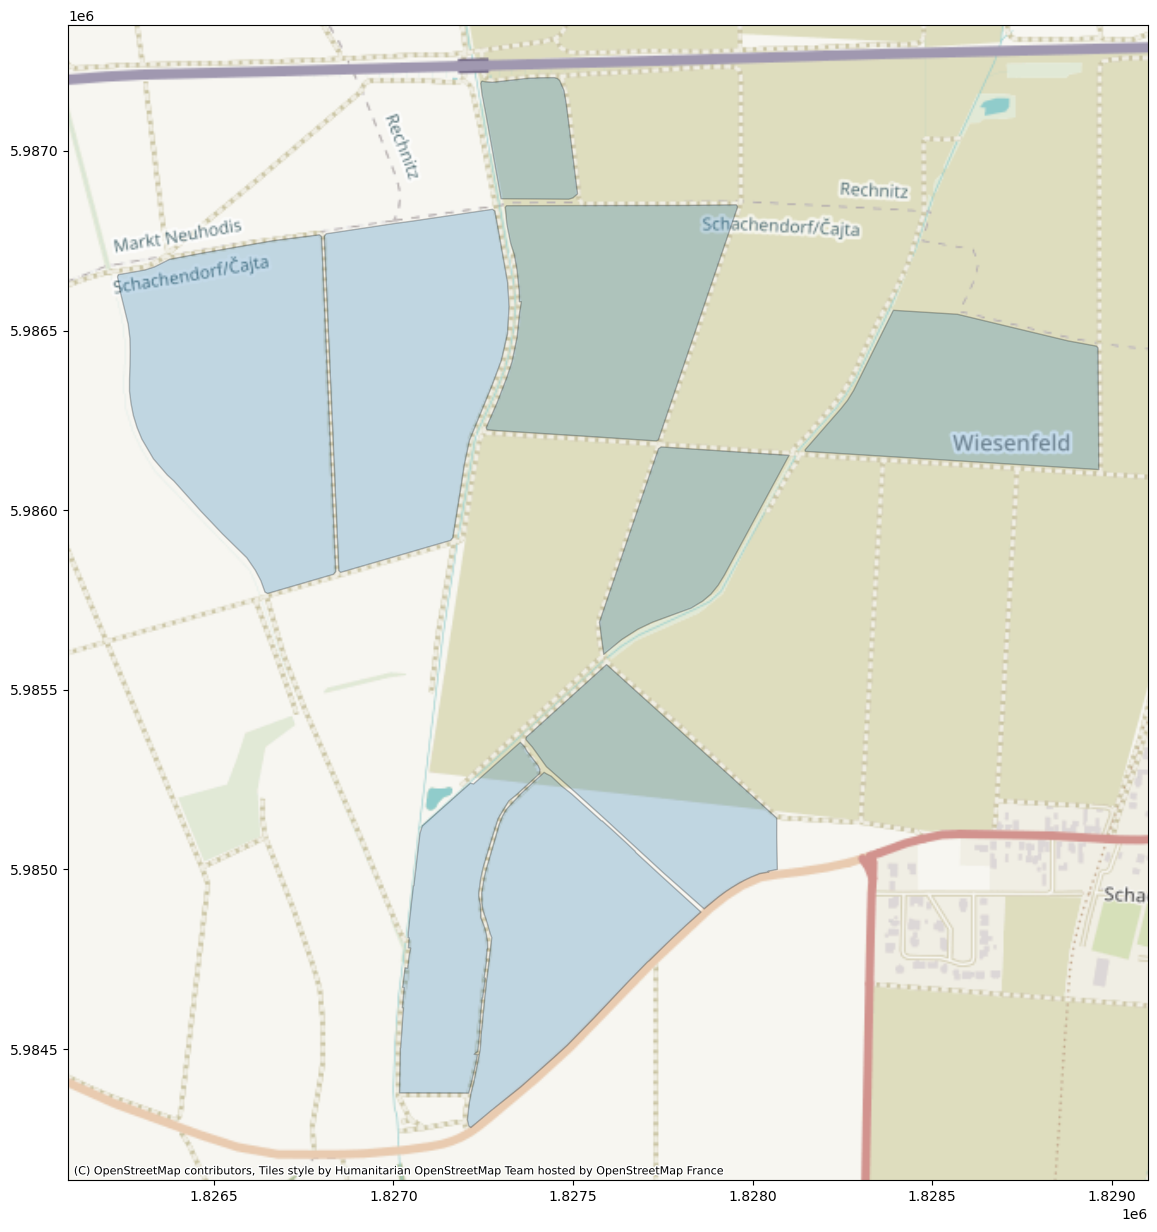

In [70]:
fields_gdf = gpd.read_file(fields)
fields_gdf["area"] = fields_gdf.geometry.area

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = fields_gdf_wm.plot(alpha=0.25, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

## 1. How to create an NDVI time series for a field of interest

### The Evalscript

In this evalscript, we are calculating NDVI. Let's remind ourselves that evalscripts operate slightly differently with Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [62]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B03",
          "B04",
          "B08",
          "dataMask",
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "ndwi",
        bands: 1
      },  
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function evaluatePixel(samples) {


    return {
      ndvi: [index(samples.B08, samples.B04)],
      ndwi: [index(samples.B08, samples.B03)],
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. The aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 

**NOTE:**
If `time_interval` is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

### The Evalscript

### The Request Body

In [64]:
fields_gdf = gpd.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2024-05-01T00:00:00Z', '2025-04-30T23:59:59Z'),
        aggregation_interval='P5D',
        resolution=(0.0001, 0.0001),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [65]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

date  ndvi_min  ndvi_max  ndvi_mean  ndvi_stDev  ndwi_min  ndwi_max  \
0  2024-07-15  0.283967  0.885318   0.823729    0.115182  0.349120  0.775738   
0  2024-08-09  0.233776  0.900531   0.853140    0.079798  0.380577  0.779449   
0  2024-08-19  0.336612  0.865464   0.830764    0.057360  0.426214  0.752549   
0  2024-10-18  0.207829  0.441789   0.288206    0.032554  0.274445  0.465517   
0  2024-10-23  0.131796  0.758824   0.218200    0.100863  0.285205  0.677547   
0  2025-01-11  0.226083  0.630911   0.489733    0.071485  0.294472  0.600634   
0  2025-02-20  0.320473  0.678720   0.589734    0.071714  0.380554  0.636049   
0  2025-03-02  0.269992  0.707304   0.597280    0.089688  0.346018  0.666578   
0  2025-03-17  0.298667  0.805128   0.686708    0.097471  0.344380  0.739130   
0  2025-03-27  0.403691  0.891063   0.816732    0.076424  0.451076  0.829038   
0  2025-04-06  0.456976  0.913514   0.861190    0.068709  0.491873  0.859856   

   ndwi_mean  ndwi_stDev  
0   0.728106    0.079970  
0   0.735880    0.047720  
0   0.717513    0.036186  
0   0.328256    0.023316  
0   0.347511    0.065349  
0   0.472135    0.038661  
0   0.572807    0.047627  
0   0.582362    0.061706  
0   0.660646    0.072322  
0   0.759226    0.063972  
0   0.806369    0.059597

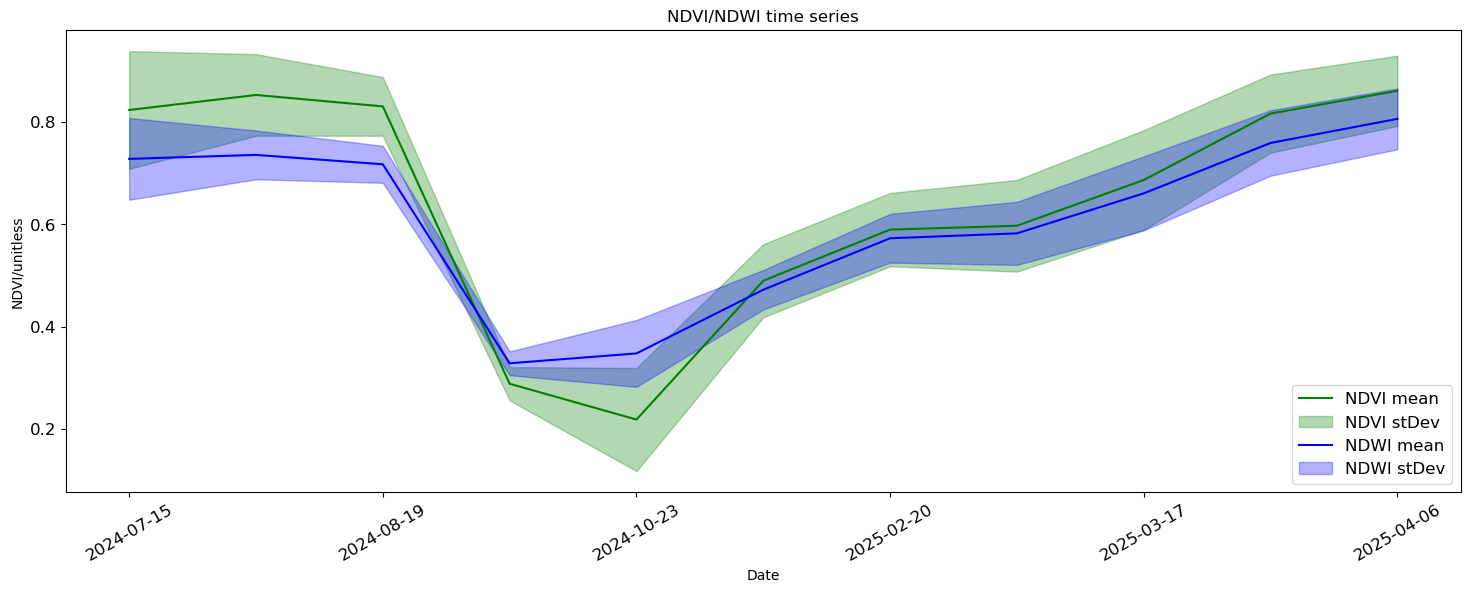

In [68]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))

# Extract data
t = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]

# Plot NDVI mean and standard deviation
ax_stat.plot(t, ndvi_mean_field1, label="NDVI mean", color="green")
ax_stat.fill_between(
    t,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    color="green",
    alpha=0.3,
    label="NDVI stDev",
)

# Plot NDWI mean and standard deviation
ax_stat.plot(t, ndwi_mean_field1, label="NDWI mean", color="blue")
ax_stat.fill_between(
    t,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    color="blue",
    alpha=0.3,
    label="NDWI stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI/NDWI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12})

plt.show()

### Creating a field of interest

Firstly, we will define some fields of interest, in this case they are the districts of Vienna. We will use the [Sentinel-2 L2A](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html) data collection in the first examples though.

/var/folders/7p/dpt81n653g7cm1ny5rm0_6q80000gn/T/ipykernel_62016/1419518379.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fields_gdf["area"] = fields_gdf.geometry.area


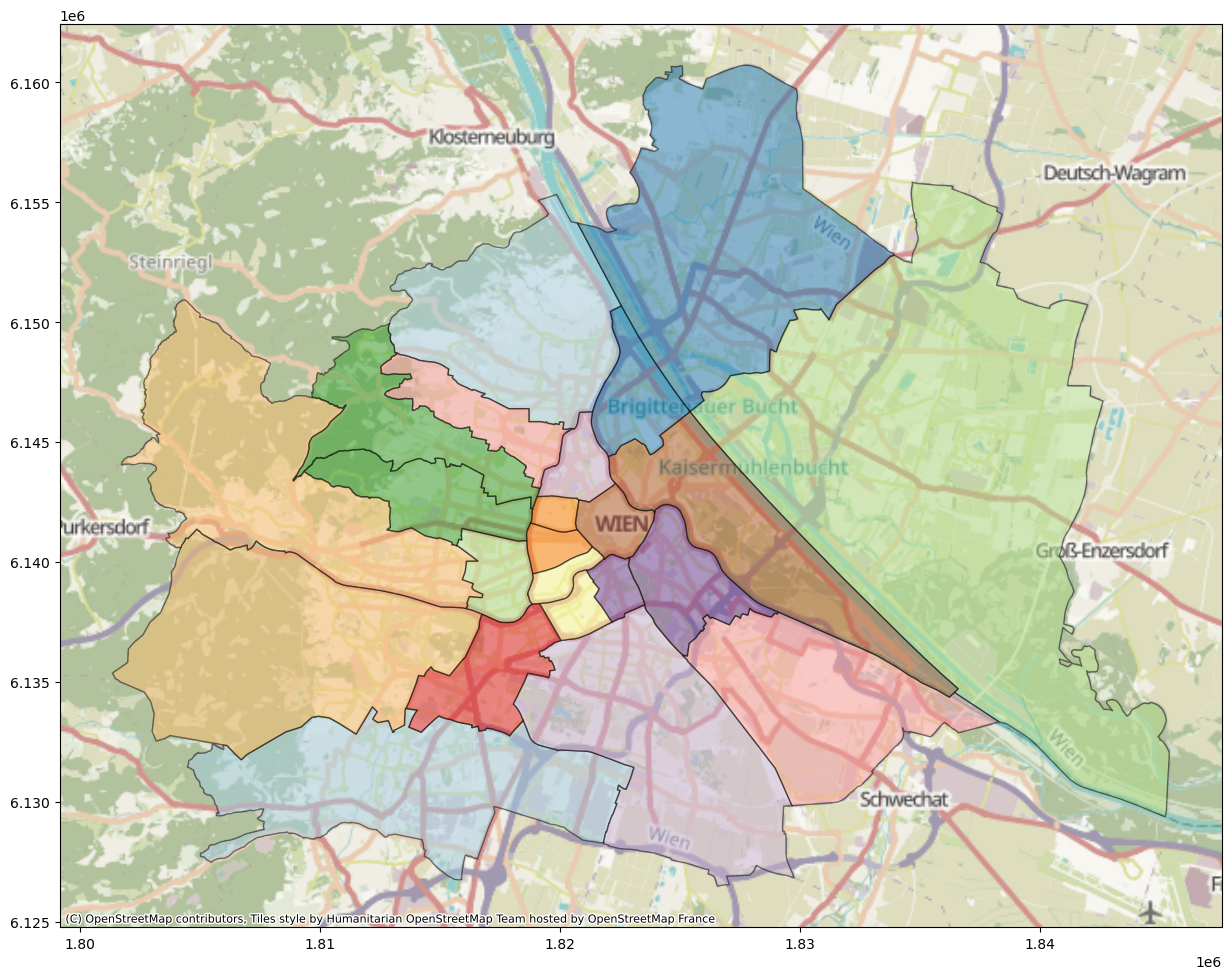

In [14]:
fields_gdf = gpd.read_file("wien_districts.geojson")
fields_gdf["area"] = fields_gdf.geometry.area

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = fields_gdf_wm.plot(alpha=0.5, cmap="Paired", edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

In [15]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

In [16]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=("2025-05-14", "2025-05-15"),
    aggregation_interval="P1D",
    resolution=(0.0001, 0.0001),
)

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[
            SentinelHubStatistical.input_data(
                DataCollection.SENTINEL2_L2A.define_from(
                    "s2l2a", service_url=config.sh_base_url
                ),
            )
        ],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.13/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [17]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 268 ms, sys: 70.8 ms, total: 339 ms
Wall time: 3.19 s


23

### Manipulation and Visualisation of our Output

In [18]:
# Helper Utility Functions


# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)


def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

In [26]:
# Convert the statistics to DataFrames and assign the 'id' column
ndvi_dfs = [
    stats_to_df(polygon_stats).assign(id=id)
    for polygon_stats, id in zip(ndvi_stats, fields_gdf["BEZIRK"].values)
]

# Concatenate all DataFrames into a single DataFrame
ndvi_df = pd.concat(ndvi_dfs)

# Display the resulting DataFrame
ndvi_df

interval_from interval_to  ndvi_B0_min  ndvi_B0_max  ndvi_B0_mean  \
0    2025-05-14  2025-05-15    -0.656477     1.000000      0.542193   
0    2025-05-14  2025-05-15    -0.358621     1.000000      0.642954   
0    2025-05-14  2025-05-15    -0.226190     0.922775      0.305175   
0    2025-05-14  2025-05-15    -0.507156     0.937131      0.508849   
0    2025-05-14  2025-05-15    -0.366300     0.926926      0.540374   
0    2025-05-14  2025-05-15    -0.294189     1.000000      0.321848   
0    2025-05-14  2025-05-15    -0.538187     0.970246      0.539952   
0    2025-05-14  2025-05-15    -0.339578     0.980803      0.695715   
0    2025-05-14  2025-05-15    -0.292564     0.962264      0.583617   
0    2025-05-14  2025-05-15    -0.498539     0.946227      0.446708   
0    2025-05-14  2025-05-15    -0.328959     0.978723      0.426737   
0    2025-05-14  2025-05-15    -0.449589     1.000000      0.781447   
0    2025-05-14  2025-05-15    -0.310990     0.986620      0.743153   
0    2025-05-14  2025-05-15    -0.125668     0.925243      0.240647   
0    2025-05-14  2025-05-15    -0.158670     0.932679      0.254577   
0    2025-05-14  2025-05-15    -0.073208     0.943610      0.273200   
0    2025-05-14  2025-05-15    -1.000000     0.978461      0.536084   
0    2025-05-14  2025-05-15    -0.270686     0.968397      0.309707   
0    2025-05-14  2025-05-15    -0.311535     0.960064      0.291340   
0    2025-05-14  2025-05-15    -0.133710     0.955955      0.258105   
0    2025-05-14  2025-05-15    -0.059190     0.924759      0.233270   
0    2025-05-14  2025-05-15    -0.143141     0.962000      0.230546   
0    2025-05-14  2025-05-15    -0.478357     0.934947      0.428254   

   ndvi_B0_stDev  ndvi_B0_sampleCount  ndvi_B0_noDataCount  id  
0       0.300516               722736               332894  23  
0       0.270179               511578               207845  19  
0       0.257357               139120                69293  20  
0       0.243244              1025244               484514  21  
0       0.267144              2839902              1597890  22  
0       0.242922                67445                19432  15  
0       0.313746               207152               100929  16  
0       0.281792               427812               287905  17  
0       0.282247               240618               162676  18  
0       0.274585               584205               301398  11  
0       0.258518               191649                92430  12  
0       0.215917               796608               338549  13  
0       0.262475              1042580               631327  14  
0       0.193421                31242                11488   7  
0       0.209287                16471                 2932   8  
0       0.219924                65925                29481   9  
0       0.293583               737802               351404  10  
0       0.252812               212058               121550   3  
0       0.250993                36842                14942   4  
0       0.211759                47967                23216   5  
0       0.195163                41328                23267   6  
0       0.244183                56430                21219   1  
0       0.331779               934030               699236   2

In the below cell, we convert the mean NDVI column into a list and then insert it in the pandas geodataframe we created earlier. We can then visualise mean NDVI using this column and an appropriate color map.

In [ ]:
# Extract the mean NDVI values from the DataFrame and convert to a list
mean_ndvi = ndvi_df["ndvi_B0_mean"].tolist()

# Insert the mean NDVI values into the GeoDataFrame as a new column
fields_gdf.insert(1, "mean_ndvi", mean_ndvi)

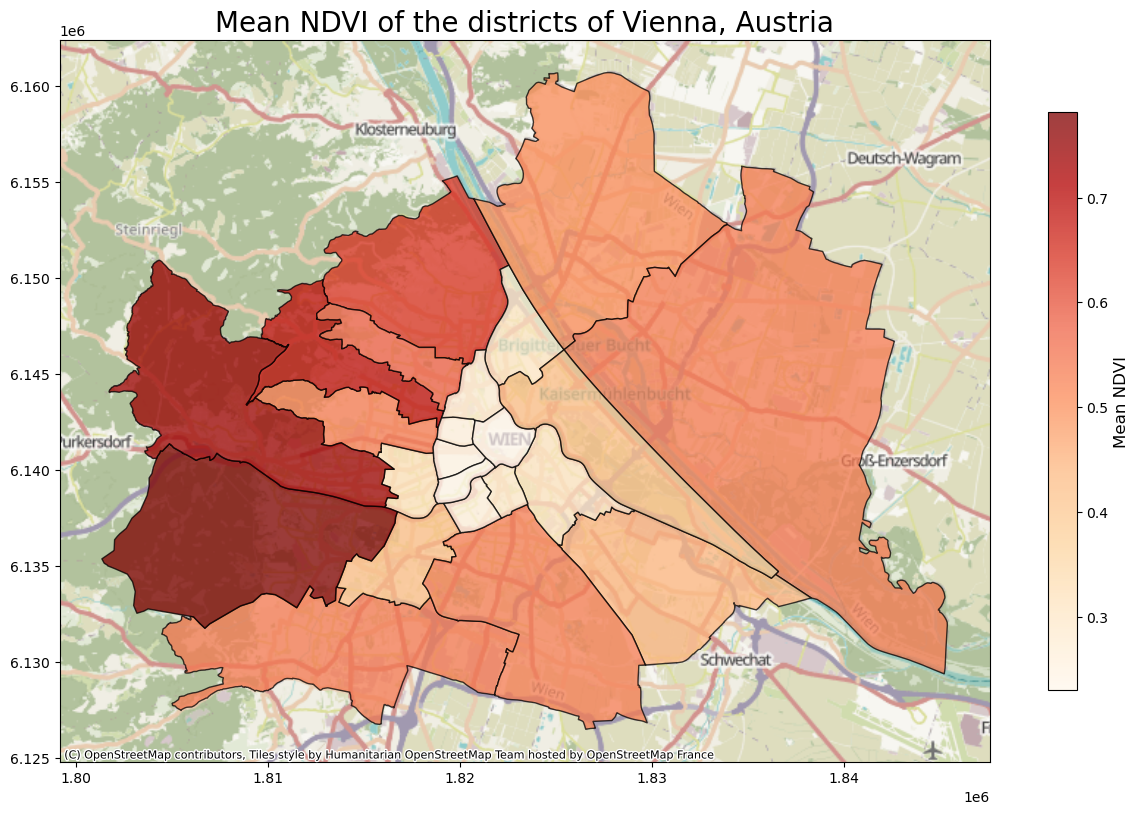

In [58]:
# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the GeoDataFrame
mappable = fields_gdf_wm.plot(
    column="mean_ndvi", cmap="OrRd", edgecolor='black', alpha=0.75, ax=ax
)

# Get the ScalarMappable
mappable = ax.collections[0] # Assuming the first collection is the one with the colormap

# Add the basemap
cx.add_basemap(ax)

# Add a title
ax.set_title("Mean NDVI of the districts of Vienna, Austria", fontsize=20)

# Create the colorbar
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=20) # Adjust shrink and aspect as desired
cbar.ax.tick_params(labelsize=10) # Adjust the font size of the tick labels
cbar.set_label("Mean NDVI", fontsize=12) # Adjust the label's font size

plt.show()

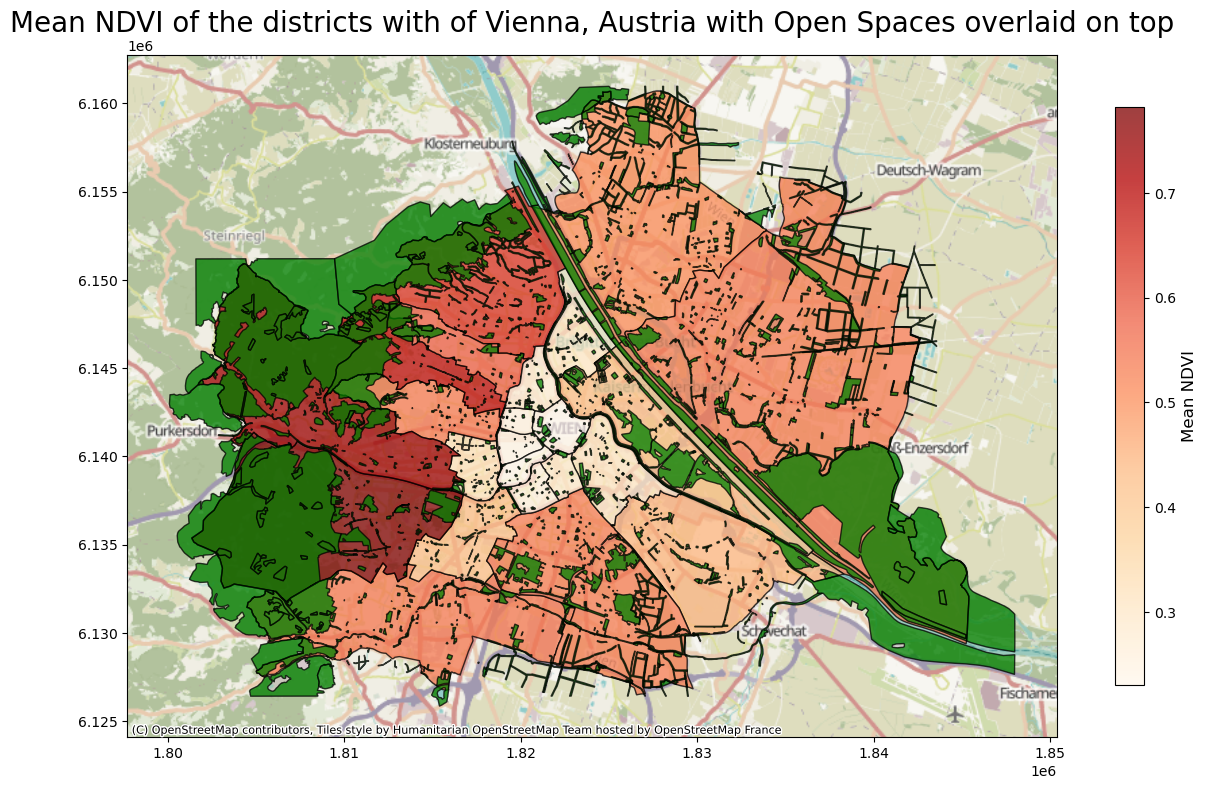

In [59]:
openspaces = gpd.read_file("public_greenspaces.geojson")
openspaces["area"] = openspaces.geometry.area

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the GeoDataFrame
mappable = fields_gdf_wm.plot(
    column="mean_ndvi", cmap="OrRd", edgecolor='black', alpha=0.75, ax=ax
)
mappable2 = openspaces.plot(ax=ax, color='green', edgecolor='black', alpha=0.75, label='Extra Layer')

# Get the ScalarMappable
mappable = ax.collections[0] # Assuming the first collection is the one with the colormap

# Add the basemap
cx.add_basemap(ax)

# Add a title
ax.set_title("Mean NDVI of the districts with of Vienna, Austria with Open Spaces overlaid on top", fontsize=20)

# Create the colorbar
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=20) # Adjust shrink and aspect as desired
cbar.ax.tick_params(labelsize=10) # Adjust the font size of the tick labels
cbar.set_label("Mean NDVI", fontsize=12) # Adjust the label's font size

plt.show()